# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Installing fastai2 and importing vision module.

In [ ]:
!pip install -Uq fastai2
from fastai.vision.all import *

     |████████████████████████████████| 179 kB 8.2 MB/s 


# Load and transform data

Getting image for augmented train dataset and validation dataset

In [ ]:
path = '/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Data/data_15/train_augmentation'
test_path = '/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Data/data_15/validation'
fns = get_image_files(path)

In [ ]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  
  def __getitem__(self, i): return self.loaders[i]

  train,valid = add_props(lambda i,self: self[i])

Defining DataBlock container to build datasets and dataloader. Splitting our augmented dataset on train (80%) and validation (20%) with a fixed seed to get replicable splits.

In [ ]:
hotels = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label
)

Calling dataloaders to load data and defining 32 as the batch size.

In [ ]:
dls = hotels.dataloaders(path, bs=32)

Showing images with their labels to see they were loaded correctly.

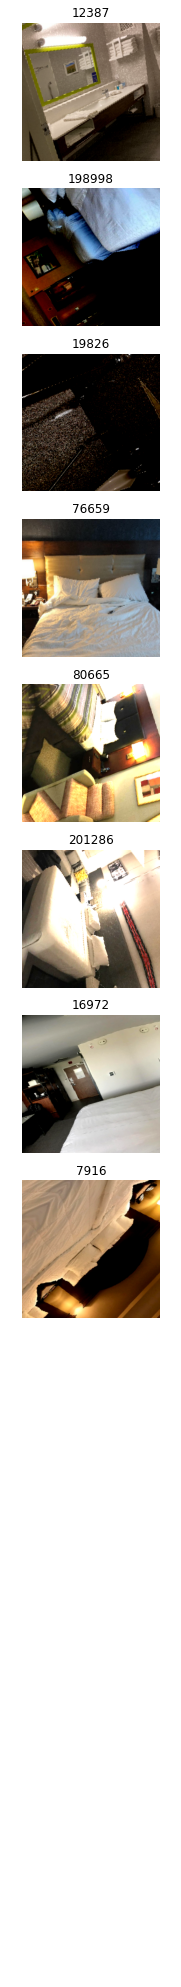

In [ ]:
dls.valid.show_batch(max_n=8, nrows=12)

# Optimized Training

Defining our model using vision_learner, we pass our dataloaders with all settings defined, define the model to use, in this case **DenseNet201**, setting pretrained to True to load the pretrained model and use Transfer Learning, setting some metrics such as accuracy, error_rate, dice and multi dice, setting our loss function as Label Smoothing Cross Entropy and our optimization function as AdamW with a weight decay of 0.05 and eps of 1e-3 and finally a set of callbacks, one to show graphs of the training progress and the second to perform early stopping if we don't see an improvement in more than 5 epochs.

In [ ]:

learn = vision_learner(dls, densenet201,
                metrics=[accuracy,error_rate, Dice, DiceMulti], 
                pretrained=True,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=QHAdam,
                cbs=[ShowGraphCallback()])

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

Start training model using fine tuning for 70 epochs and setting a base learning rate of 0.005 which was found using the lr finder function from FastAI

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,4.736969,4.083415,0.337640,0.662360,336.766113,0.320612,35:13


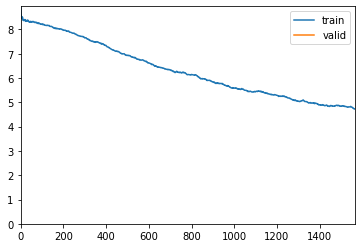

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,3.192012,2.839636,0.630861,0.369139,370.738521,0.620192,09:44
1,2.512856,2.285602,0.753429,0.246571,382.420182,0.745534,09:41
2,2.081963,2.020386,0.815789,0.184211,389.783492,0.810366,09:42
3,1.862193,1.922993,0.837640,0.162360,391.873464,0.833099,09:41
4,1.799725,1.877709,0.847209,0.152791,392.039193,0.843212,09:42
5,1.784073,1.844347,0.858533,0.141467,393.114799,0.854418,09:45
6,1.758251,1.821653,0.857735,0.142265,392.289266,0.854551,09:44
7,1.763262,1.809579,0.864912,0.135088,395.298756,0.862283,09:45
8,1.744725,1.790944,0.868660,0.131340,394.605867,0.866243,09:44
9,1.714328,1.780691,0.870574,0.129426,393.247966,0.868725,09:46


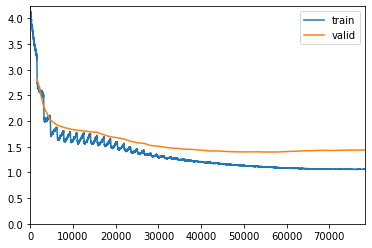

In [ ]:
learn.fine_tune(50, 0.004)

Saving model in both .pth and .pkl formats.

In [ ]:
save_path = '/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Notebooks/Models/Densenet'
learn.save(f'{save_path}/model_densenet_final')

Path('/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Notebooks/Models/Densenet/model_densenet_final.pth')

In [ ]:
learn.export(f'{save_path}/model_densenet_final_pickle.pkl')

# Results Visualization

Helper function to plot results from metrics.

In [ ]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, final_losses=True, perc=.5, **kwargs):
    
    n_values = len(self.recorder.values)
    if n_values < 2:
        print('not enough values to plot a chart')
        return
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    metric_names = [m.replace("valid_", "") for m in self.metric_names[1:-1] if 'loss' not in m and 'train' not in m]
    if final_losses:
        sel_idxs = int(round(n_values * perc))
        if sel_idxs < 2:
            final_losses = False 
        else:
            names = names + ['train_final_loss', 'valid_final_loss']
            self.loss_idxs = L([i for i,n in enumerate(self.metric_names[1:-1]) if 'loss' in n])
            metrics = np.concatenate([metrics, metrics[:, self.loss_idxs]], -1) 

    n = int(1 + final_losses + len(self.metrics))
    if nrows is None and ncols is None:
        if n <= 3: 
            nrows = 1
        else:
            nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6 + ncols - 1, nrows * 4 + nrows - 1)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = axs.flatten()[:n]
    for i,name in enumerate(names):
        xs = np.arange(0, len(metrics))
        if name in ['train_loss', 'valid_loss']: 
            ax_idx = 0
            m = metrics[:,i]
            title = 'losses'
        elif name in ['train_final_loss', 'valid_final_loss']: 
            ax_idx = 1
            m = metrics[-sel_idxs:,i]
            xs = xs[-sel_idxs:]
            title = 'final losses'
        else: 
            ax_idx = metric_names.index(name.replace("valid_", "").replace("train_", "")) + 1 + final_losses
            m = metrics[:,i]
            title = name.replace("valid_", "").replace("train_", "")
        if 'train' in name:
            color = '#1f77b4'
            label = 'train'
        else:
            color = '#ff7f0e'
            label = 'valid'
            axs[ax_idx].grid(color='gainsboro', linewidth=.5)
        axs[ax_idx].plot(xs, m, color=color, label=label)
        axs[ax_idx].set_xlim(xs[0], xs[-1])
        axs[ax_idx].legend(loc='best')
        axs[ax_idx].set_title(title)
    plt.show()

Final result metrics.

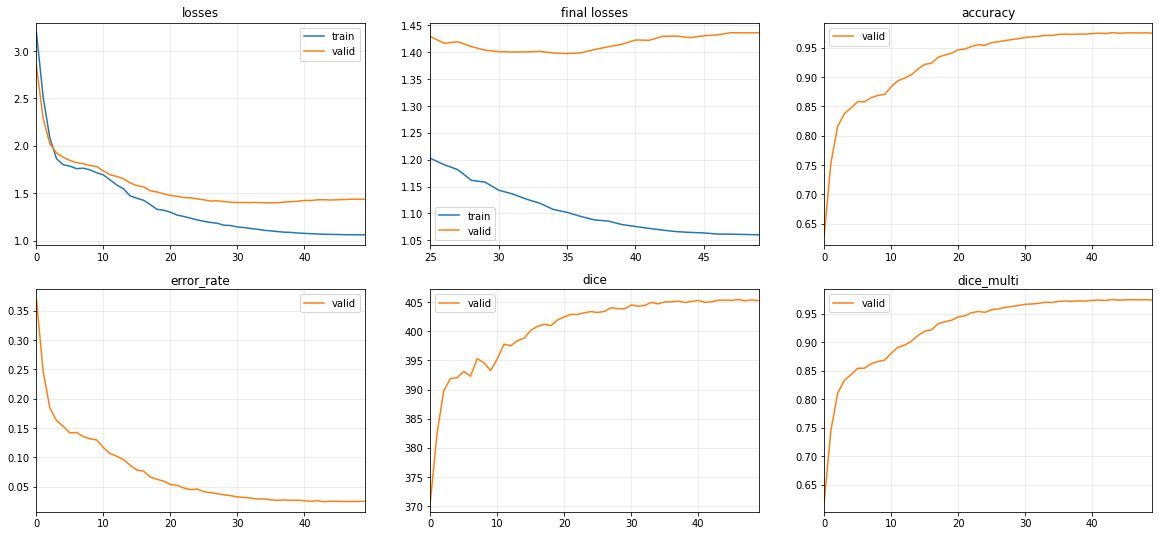

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

Getting top 5 losses

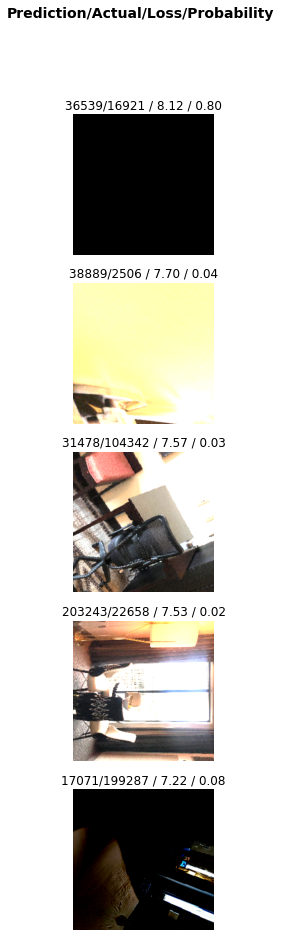

In [ ]:
interp.plot_top_losses(5, nrows=5)

In [ ]:
learn.validate()

(#5) [1.4363086223602295,0.9751195907592773,0.024880383163690567,405.2830472049597,0.974270615962244]

In [ ]:
test_dl = dls.test_dl(get_image_files(test_path))
y_preds = learn.get_preds(dl=test_dl)
dls = hotels.dataloaders(test_path)
y_preds = np.argmax(y_preds[0], axis = 1)
y_preds

RuntimeError: ignored

# Test model


In [ ]:
import pathlib

In [ ]:
from google.colab import drive
from fastai.vision.all import *
from sklearn.metrics import classification_report
import pathlib

In [ ]:
model_path = '/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Notebooks/Models/Densenet/test_model'
learn = learn.load(model_path)

In [ ]:
y_pred, y_true = learn.get_preds()
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_pred, target_names=dls.vocab, zero_division=1))

              precision    recall  f1-score   support

      100206       0.83      1.00      0.90        19
      100297       1.00      1.00      1.00        16
       10031       1.00      1.00      1.00        21
      100326       1.00      1.00      1.00        22
      100410       0.95      1.00      0.98        20
       10054       0.95      1.00      0.98        20
        1007       0.88      1.00      0.94        15
        1009       1.00      1.00      1.00        18
      101242       0.96      1.00      0.98        46
      101899       1.00      1.00      1.00        18
      102219       1.00      1.00      1.00        19
       10290       0.96      1.00      0.98        26
      102995       0.90      1.00      0.95        19
      103150       0.91      0.95      0.93        21
      103319       1.00      1.00      1.00        17
      103379       1.00      1.00      1.00        21
      103458       0.92      1.00      0.96        11
      103533       1.00    

In [ ]:
root_path = "/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Data/data_15"
p = pathlib.Path(root_path)
data = ImageDataLoaders.from_folder(path = p, train = "validation", validate="", bs=32, item_tfms=Resize(128))

In [ ]:
y_pred, y_true = learn.get_preds(dl = data.train)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_pred, target_names=dls.vocab, zero_division=1))

              precision    recall  f1-score   support

      100206       0.00      0.00      0.00         2
      100297       0.00      0.00      0.00         2
       10031       0.00      0.00      0.00         2
      100326       0.00      0.00      0.00         2
      100410       0.00      0.00      0.00         2
       10054       0.00      0.00      0.00         2
        1007       1.00      0.00      0.00         5
        1009       0.00      0.00      0.00         2
      101242       0.33      0.25      0.29         4
      101899       0.00      0.00      0.00        40
      102219       1.00      0.00      0.00         2
       10290       0.00      0.00      0.00         3
      102995       0.00      0.00      0.00         2
      103150       1.00      0.00      0.00         2
      103319       1.00      0.00      0.00         7
      103379       0.00      0.00      0.00         2
      103458       0.00      0.00      0.00         3
      103533       1.00    